In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
from sklearn.utils import resample
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [15]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def design_matrix(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

# Plot Franke Function

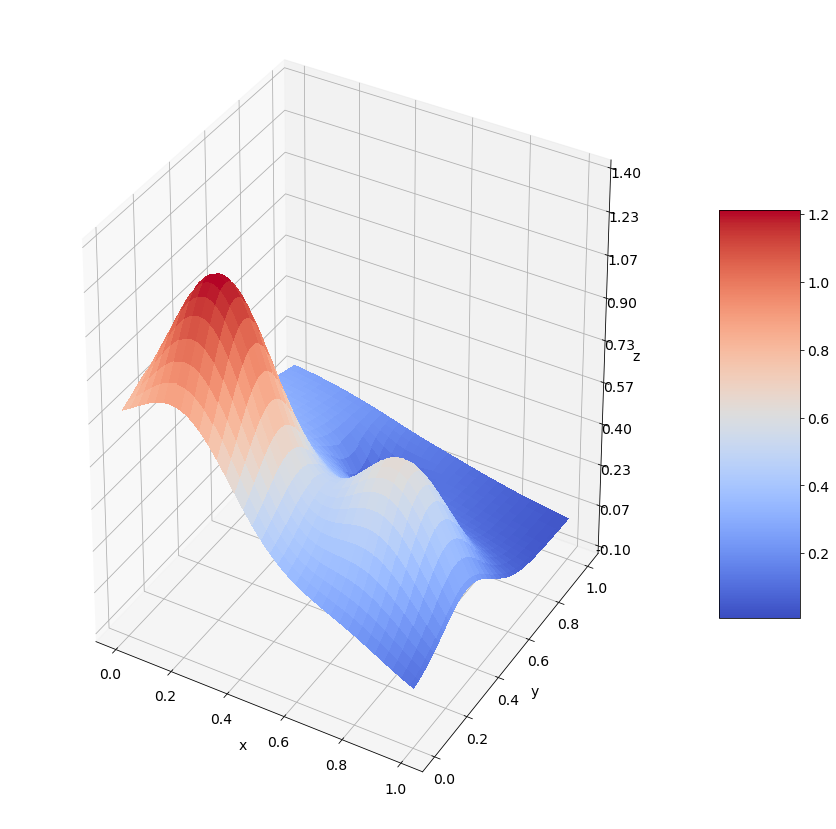

In [16]:
x = np.arange(0, 1.01, 0.01)
y = np.arange(0, 1.01, 0.01)
x_gr, y_gr = np.meshgrid(x,y)
z = FrankeFunction(x_gr, y_gr) #+ np.random.normal(0,0.1, 21)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection="3d")

# Plot the surface.
surf = ax.plot_surface(x_gr, y_gr, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
#fig.savefig('franke_function_surface.jpg', dpi=1000, bbox_inches='tight')

# Simple OLS over polynomial degree

In [17]:
def OLS_test_poly_degree(npoints, lower, upper, noise, sigma, scaling):
    
    np.random.seed(2)
    
    #initialize arrays to save results
    test_MSEs = []
    test_R2s = []
    train_MSEs = []
    train_R2s = []
    betas = []
    var_betas = []
    
    poly_order_range = range(lower, upper+1)
    
    # create x,y data
    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    
    x_gr, y_gr = np.meshgrid(x,y)
    
    # create z data with Franke function with optional noise added
    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))
    
    # iterate over every polynomial order
    for order in poly_order_range:

        X = design_matrix(x, y, order)
        
        # train test split
        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.2, random_state = 1)
        
        # optional scaling of data by mean of training sets
        X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)
        
        # calculate beta parameters and their variance
        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        var_beta = sigma**2 * np.diag(np.linalg.pinv(X_train.T @ X_train))
        
        # calculate predicted train and test data
        z_tilde = X_train @ beta
        z_pred = X_test @ beta

        # append results of MSE and R2 values
        test_MSEs.append(MSE(z_pred, z_test))
        train_MSEs.append(MSE(z_train,z_tilde))
        test_R2s.append(R2(z_test,z_pred))
        train_R2s.append(R2(z_train,z_tilde))
        betas.append(beta)  
        var_betas.append(var_beta)

    return test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas

# No Scaling Test, 100 data points, poly degree 1-15

(0.63, 1.02)

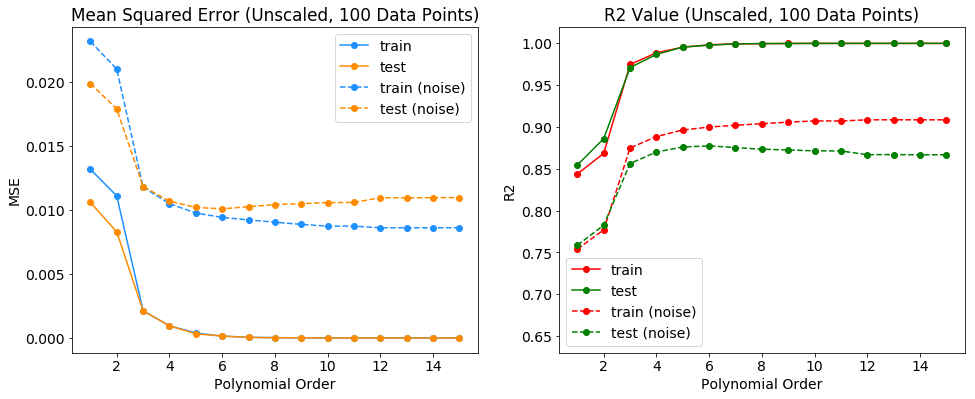

In [18]:
npoints = 100
lower_poly = 1
upper_poly = 15
poly_order_range = range(lower_poly, upper_poly+1)

test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas =  OLS_test_poly_degree(npoints, lower_poly, 
                                                                upper_poly, noise=0, sigma=0, scaling=0)

N_test_MSEs, N_test_R2s, N_train_MSEs, N_train_R2s, N_betas, N_var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                            upper_poly, noise=1, sigma=0.1, scaling=0)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(poly_order_range, train_MSEs, '-o', color='dodgerblue', label='train')
ax[0].plot(poly_order_range, test_MSEs, '-o', color='darkorange', label='test')
ax[0].plot(poly_order_range, N_train_MSEs, '--o', color='dodgerblue', label='train (noise)')
ax[0].plot(poly_order_range, N_test_MSEs, '--o', color='darkorange', label='test (noise)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('MSE')
ax[0].set_title('Mean Squared Error (Unscaled, 100 Data Points)')
ax[0].legend()
#ax[0,0].set_ylim(-0.001, 0.02)

ax[1].plot(poly_order_range, train_R2s, '-o', color='red', label='train')
ax[1].plot(poly_order_range, test_R2s, '-o', color='green', label='test')
ax[1].plot(poly_order_range, N_train_R2s, '--o', color='red', label='train (noise)')
ax[1].plot(poly_order_range, N_test_R2s, '--o', color='green', label='test (noise)')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 Value (Unscaled, 100 Data Points)')
ax[1].legend()
ax[1].set_ylim(0.63, 1.02)
#fig.savefig('OLS_MSE_R2_unscaled.jpg', dpi=1000, bbox_inches='tight')

In [19]:
N_test_MSEs

[0.019887035947045037,
 0.01790221586280509,
 0.01183238962611249,
 0.01069606052290181,
 0.010209222885815245,
 0.010094172748299948,
 0.010261913934887346,
 0.010427391199059692,
 0.010495989816327201,
 0.010584497243731722,
 0.010595062009423185,
 0.01096297747151402,
 0.010954030916272029,
 0.010970449789786863,
 0.010972360939997261]

# Scaling Test

In [20]:
npoints = 100
lower_poly = 1
upper_poly = 15
poly_order_range = range(lower_poly, upper_poly+1)

test_MSEs, test_R2s, train_MSEs, train_R2s, betas, var_betas =  OLS_test_poly_degree(npoints, lower_poly, 
                                                                upper_poly, noise=0, sigma=0, scaling=1)

N_test_MSEs, N_test_R2s, N_train_MSEs, N_train_R2s, N_betas, N_var_betas =  OLS_test_poly_degree(npoints, lower_poly,
                                                                            upper_poly, noise=1, sigma=0.1, scaling=1)

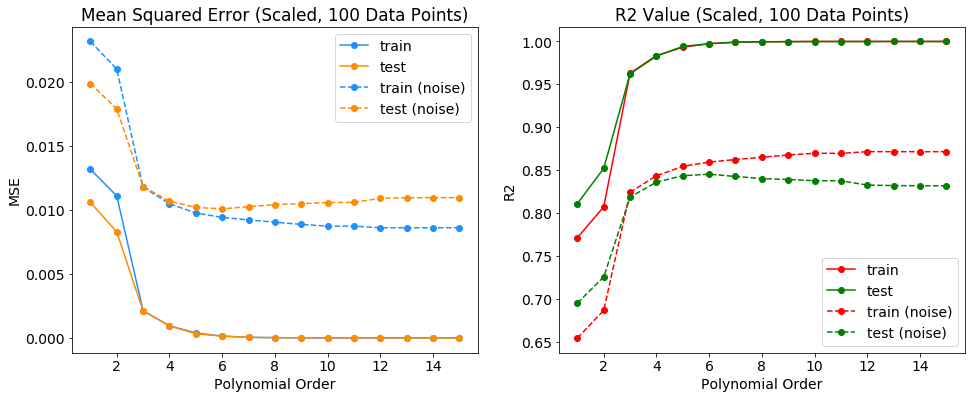

In [21]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].plot(poly_order_range, train_MSEs, '-o', color='dodgerblue', label='train')
ax[0].plot(poly_order_range, test_MSEs, '-o', color='darkorange', label='test')
ax[0].plot(poly_order_range, N_train_MSEs, '--o', color='dodgerblue', label='train (noise)')
ax[0].plot(poly_order_range, N_test_MSEs, '--o', color='darkorange', label='test (noise)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('MSE')
ax[0].set_title('Mean Squared Error (Scaled, 100 Data Points)')
ax[0].legend()
#ax[0,0].set_ylim(-0.001, 0.02)

ax[1].plot(poly_order_range, train_R2s, '-o', color='red', label='train')
ax[1].plot(poly_order_range, test_R2s, '-o', color='green', label='test')
ax[1].plot(poly_order_range, N_train_R2s, '--o', color='red', label='train (noise)')
ax[1].plot(poly_order_range, N_test_R2s, '--o', color='green', label='test (noise)')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 Value (Scaled, 100 Data Points)')
ax[1].legend()
#fig.savefig('OLS_MSE_R2_scaled.jpg', dpi=1000, bbox_inches='tight')

# Beta Parameter Plotting

Text(0.5, 1.0, 'Beta Parameters vs. Poly. Order of OLS Models (100 Data Points, Noisy)')

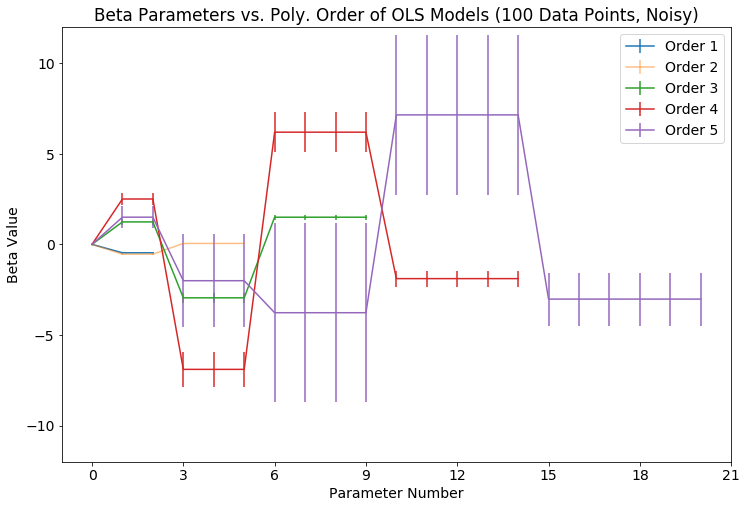

In [22]:
n = 10
fig,ax = plt.subplots(figsize=(12,8))

# use +/- 1 STD (sqrt of variance) for the extent of error bars
ax.errorbar(range(3), N_betas[0][:, n], yerr=np.sqrt(N_var_betas[0][:]),  label='Order 1')
ax.errorbar(range(6) ,N_betas[1][:, n], yerr=np.sqrt(N_var_betas[1][:]),  label='Order 2', alpha=0.5)
ax.errorbar(range(10),N_betas[2][:, n], yerr=np.sqrt(N_var_betas[2][:]),  label='Order 3')
ax.errorbar(range(15),N_betas[3][:, n], yerr=np.sqrt(N_var_betas[3][:]), label='Order 4')
ax.errorbar(range(21),N_betas[4][:, n], yerr=np.sqrt(N_var_betas[4][:]),  label='Order 5')

ax.set_ylim(-12, 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
ax.set_xlabel('Parameter Number')
ax.set_ylabel('Beta Value')
ax.set_title('Beta Parameters vs. Poly. Order of OLS Models (100 Data Points, Noisy)')
#fig.savefig('OLS_beta_variance.jpg', dpi=1000, bbox_inches='tight')

# Bootstrap and Bias Variance

In [23]:
def OLS_test_bootstrap(npoints, lower, upper, noise, sigma, scaling, nbootstraps):
    
    np.random.seed(6)
    errors = []
    biases = []
    variances = []
    poly_order_range = range(lower, upper+1)

    n_bootstraps = nbootstraps
    
    x = np.linspace(0, 1, npoints)

    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)
    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))
        
    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.2, random_state = 1)

        X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)

        z_test = np.expand_dims(z_test, 2)
        features = int((order+1)*(order+2)/2)

        # intialize empty z prediction matrix to save predictions for all n bootstraps
        z_pred = np.empty((z_test.shape[0], npoints, n_bootstraps))

        for i in range(n_bootstraps):
            X_train_, z_train_ = resample(X_train, z_train)

            beta = np.linalg.pinv(X_train_.T @ X_train_) @ X_train_.T @ z_train_
            
            ztilde = X_train_ @ beta

            z_pred[:, :, i] = X_test @ beta

        # calculate test error, bias, and variance to analyze bias variance tradeoff    
        error = np.mean( np.mean((z_test - z_pred)**2, axis=2) )
        bias = np.mean( (z_test - np.mean(z_pred, axis=2, keepdims=True))**2 )
        variance = np.mean( np.var(z_pred, axis=2, keepdims=True) )

        errors.append(error)
        biases.append(bias)
        variances.append(variance)

    return errors, biases, variances

# Bootstrapping error values

In [24]:
npoints = 100
lower_poly = 1
upper_poly = 5
poly_order_range = range(lower_poly, upper_poly+1)
nbootstraps = 100
noise = 1
sigma = 0.1
scaling = 1

errors, biases, variances = OLS_test_bootstrap(npoints, lower_poly, upper_poly, noise, sigma, scaling, nbootstraps)

In [25]:
errors

[0.019892647180198227,
 0.017692632822120368,
 0.012288547263893636,
 0.011222103637365642,
 0.011069647896463973]

# Bias variance tradeoff analysis with 50 data points, 100 bootstraps


In [26]:
npoints = 50
lower_poly = 1
upper_poly = 15
poly_order_range = range(lower_poly, upper_poly+1)
nbootstraps = 100
noise = 1
sigma = 0.1
scaling = 1

errors, biases, variances = OLS_test_bootstrap(npoints, lower_poly, upper_poly, noise, sigma, scaling, nbootstraps)

Text(0.5, 1.0, 'Bias Variance Tradeoff in Bootstrapped OLS (100 Bootstraps, 50 Data Points)')

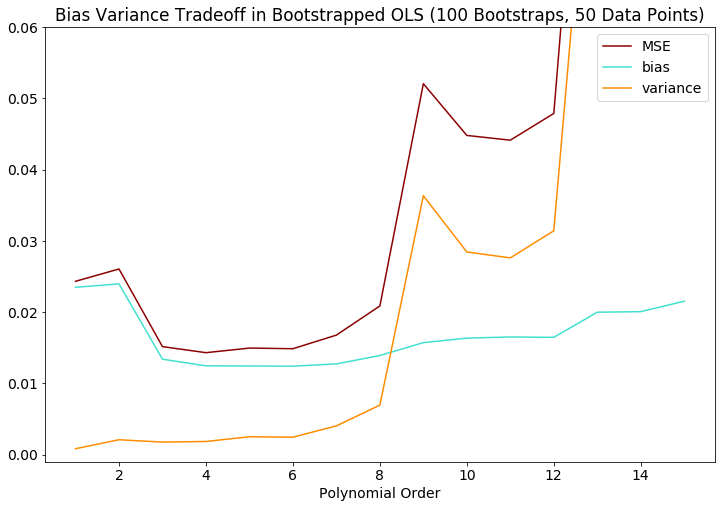

In [27]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, errors, color='darkred', label='MSE')
ax.plot(poly_order_range, biases, color='turquoise', label='bias')
ax.plot(poly_order_range, variances, color='darkorange', label='variance')
#ax.vlines(3, -1, 1, color='grey', linestyles='--')
ax.set_ylim(-0.001, 0.06)
ax.legend()
ax.set_xlabel('Polynomial Order')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Bias Variance Tradeoff in Bootstrapped OLS (100 Bootstraps, 50 Data Points)')
#fig.savefig('OLS_bias_variance.jpg', dpi=1000, bbox_inches='tight')

# Cross Validation

In [28]:
def OLS_CV(npoints, lower, upper, noise, sigma, nfolds, scaling):
    
    np.random.seed(7)
    
    poly_order_range = range(lower, upper+1)
    
    # use number of folds to initialize number of splits and array to average over
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold = np.zeros((len(poly_order_range), k))

    x = np.linspace(0, 1, npoints)
    
    y = np.linspace(0, 1, npoints)

    x_gr, y_gr = np.meshgrid(x,y)
    
    if noise==1:
        z = FrankeFunction(x_gr, y_gr) + np.random.normal(0, 0.01, (len(x),len(x)))
    else:
        z = FrankeFunction(x_gr, y_gr)

    i = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)
        j = 0
        
        # split the data k times
        for train_inds, test_inds in kfold.split(X):
          
            X_train_origin = X[train_inds]
            z_train_origin = z[train_inds]
            X_test_origin = X[test_inds]
            z_test_origin = z[test_inds]

            X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
            X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
            z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
            z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)

            beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
            ztilde = X_train @ beta
            z_pred = X_test @ beta
            
            # calculate test error for this fold configuration
            scores_KFold[i,j] = MSE(z_pred, z_test)

            j += 1
        i += 1
    # average the mse over all fold configurations
    estimated_mse_KFold = np.mean(scores_KFold, axis = 1)


    return estimated_mse_KFold


# CV test for 5-11 folds

In [29]:
npoints = 100
lower_poly = 1
upper_poly = 10
poly_order_range = range(lower_poly, upper_poly+1)
noise = 1
sigma = 0.1
mse_cvs = []
for nfolds in range(5, 11):

    mse_cv = OLS_CV(npoints, lower_poly, upper_poly, noise, sigma, nfolds, scaling=1)
    mse_cvs.append(mse_cv)

Text(0.5, 1.0, 'Cross Validation-estimated MSE for OLS (100 Data Points)')

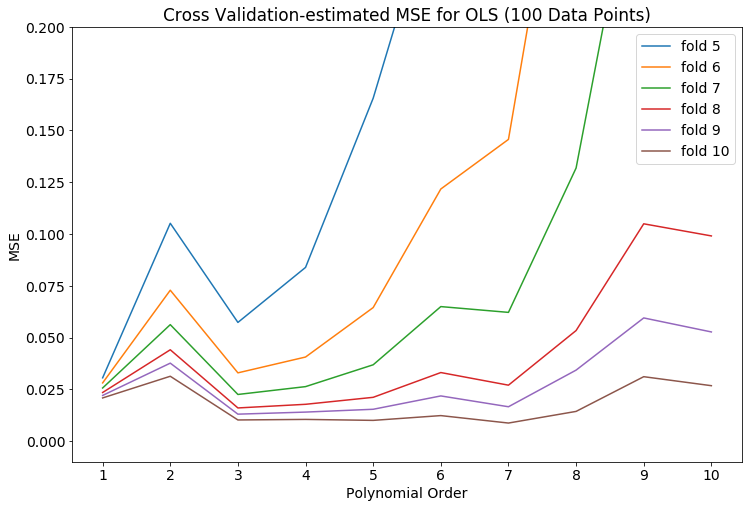

In [30]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, mse_cvs[0], label='fold 5')
ax.plot(poly_order_range, mse_cvs[1], label='fold 6')
ax.plot(poly_order_range, mse_cvs[2], label='fold 7')
ax.plot(poly_order_range, mse_cvs[3], label='fold 8')
ax.plot(poly_order_range, mse_cvs[4], label='fold 9')
ax.plot(poly_order_range, mse_cvs[5], label='fold 10')
ax.legend()
#ax.vlines(3, -1, 1, color='grey', linestyles='--')
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Polynomial Order')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Cross Validation-estimated MSE for OLS (100 Data Points)')
#fig.savefig('OLS_cross_validation.jpg', dpi=1000, bbox_inches='tight')

In [31]:
mse_cvs[5]

array([0.02084098, 0.03130501, 0.01020019, 0.0104724 , 0.01000237,
       0.01230982, 0.00871297, 0.01433576, 0.031101  , 0.02675326])